In [8]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow.compute as pc
from psm_utils import Peptidoform
import pickle

import seaborn as sns
from matplotlib import pyplot as plt

from denovo_utils.rescoring.rescore import load_configuration, save_object, load_rescorer
from denovo_utils.rescoring import DeNovoRescorer

from denovo_utils.parsers import DenovoEngineConverter

Initialize variables

In [2]:
# For loading the expanded database candidates
path_id = '/home/samva/Doctorate/data_directory/PXD028735/sage/identification/LFQ_Orbitrap_DDA_Human_01.sage.parquet'
batch_size = 50000
columns = [
    'scannr',
    'peptide',
    'proteins',
    'rank',
    'is_decoy',
    'charge',
    'peptide_len',
    'delta_next',
    'delta_best',
    'scored_candidates',
    'sage_discriminant_score',
    'spectrum_q',
]

# For training the mokapot models
path_config_ms2rescore = "/home/samva/Doctorate/DeNovo_Benchmark/configs/ms2rescore/config_default.json"
path_psm_gt = "/home/samva/Doctorate/data_directory/PXD028735/search_results/identification/LFQ_Orbitrap_DDA_Human_01.sage.tsv"
path_mgf = "/home/samva/Doctorate/data_directory/PXD028735/mgf/Orbitrap_QE/reformatted/LFQ_Orbitrap_DDA_Human_01.mgf"

path_out_mokapot = '/home/samva/Doctorate/data_directory/PXD028735/ambiguity/mokapot_models'
path_out_fgen = '/home/samva/Doctorate/data_directory/PXD028735/ambiguity/fgen.pkl'

In [3]:
configuration = load_configuration(
    path_config_ms2rescore,
    psm_file=path_psm_gt,
    spectrum_path=path_mgf
)

rescorer = DeNovoRescorer(configuration)

# 1. Load ground-truth data and train mokapot models

In [ ]:
parser = DenovoEngineConverter.select('sage')
psm_list = parser.parse(path_psm_gt, path_mgf).get_rank1_psms()

psm_list = rescorer.preprocess_psm_list(psm_list)
rescorer.retrain_deeplc(psm_list)
rescorer.add_features(psm_list)

In [ ]:
save_object(
    rescorer.fgens, 
    path_out_fgen
)

rescorer.train_mokapot_models(
    psm_list=psm_list,
    save_folder=path_out_mokapot
)

In [4]:
psm_list = load_rescorer(
        rescorer=rescorer,
        psm_path=None,
        fgen_path=path_out_fgen,
        mokapot_folder=path_out_mokapot
    )

# 2. Expand search space for a given PSM

In [5]:
# Load annotation which psms are matching and which dont
casanovo_ids = pd.read_pickle('/home/samva/Doctorate/DeNovo_Benchmark/notebooks/analysis/PXD028735/casanovo_identifications.pkl')
print(casanovo_ids.shape)
casanovo_ids.head()

# The full database search space for a given spectrum
fp = pq.read_table(
    source=path_id,
    columns=columns,
    filters=[
        ('scannr', 'in', casanovo_ids.spectrum_id.unique().tolist()),
        ('peptide_len', '<', 31)
    ]
)

(66560, 3)


In [11]:
# The casanovo PSMs
path_denovo_psms = "/home/samva/Doctorate/data_directory/PXD028735/rescoring_results/LFQ_Orbitrap_DDA_Human_01/casanovo.pkl"
with open(path_denovo_psms, 'rb') as f:
    denovo_df = pickle.load(f).to_dataframe()

In [19]:
denovo_df[
    denovo_df.spectrum_id.isin(
        casanovo_ids.loc[~casanovo_ids.correct_peptide, 'spectrum_id']
    )
].sort_values('score', ascending=False)[['peptidoform', 'spectrum_id', 'score', 'provenance_data']].head()

,peptidoform,spectrum_id,score,provenance_data
97158,"((H, None), (L, None), (A, None), (D, None), (...",controllerType=0 controllerNumber=1 scan=116061,19.094716,"{'before_rescoring_score': 0.9832468705792581,..."
96892,"((H, None), (L, None), (A, None), (D, None), (...",controllerType=0 controllerNumber=1 scan=115761,18.674546,{'before_rescoring_score': -0.0139757433245258...
96918,"((H, None), (L, None), (A, None), (D, None), (...",controllerType=0 controllerNumber=1 scan=115790,17.591609,{'before_rescoring_score': -0.0166883487855235...
94917,"((H, None), (L, None), (A, None), (D, None), (...",controllerType=0 controllerNumber=1 scan=113424,17.511404,{'before_rescoring_score': -0.0111436593917108...
95330,"((H, None), (L, None), (A, None), (D, None), (...",controllerType=0 controllerNumber=1 scan=113912,17.411017,{'before_rescoring_score': -0.0163231780452113...


### 2.1 Define which PSMs to expand

In [29]:
denovo_df.loc[
    denovo_df.spectrum_id=='controllerType=0 controllerNumber=1 scan=116061',
    ['metadata']
].values

array([[{'aa_scores': '0.98039,0.95406,0.98506,0.98823,0.98905,0.98253,0.98815,0.98729,0.97235,0.98675,0.98646,0.98814,0.98605,0.98563,0.98567,0.98686,0.98679,0.98712,0.98628,0.94366,0.98270,0.98675,0.98329,0.98865,0.98895,0.98734,0.98539,0.97838,0.98808,0.98798', 'calc_mass_to_charge': '1004.8561043668799', 'spectra_ref': 'ms_run[1]:index=98570', 'scans': '116061', 'peptide_evidence': HLADLAGNSEVLLPVPAFNVLN[UNIMOD:7]GGSHAGNK/3}]],
      dtype=object)

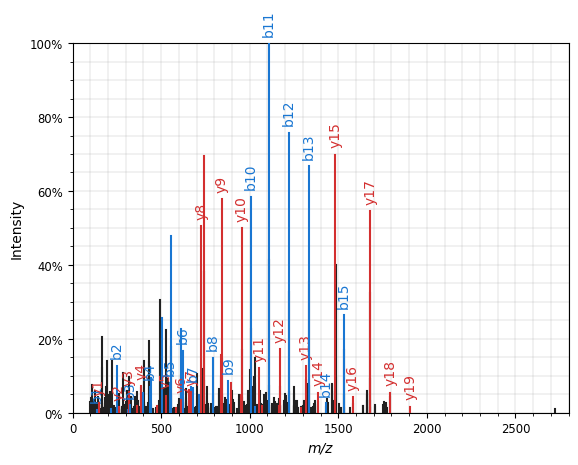

In [34]:
from denovo_utils.analysis.visualization import plot_spectrum

plot_spectrum(
    mgf_path=path_mgf,
    spectrum_id='controllerType=0 controllerNumber=1 scan=116061',
    peptide='HLADLAGNSEVLLPVPAFNVLN[UNIMOD:7]GGSHAGNK/3'
)

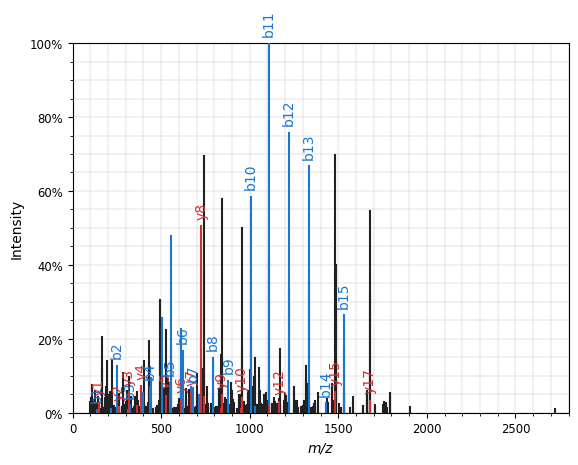

In [36]:
plot_spectrum(
    mgf_path=path_mgf,
    spectrum_id='controllerType=0 controllerNumber=1 scan=116061',
    peptide='HIADLAGNSEVILPVPAFNVINGGSHAGNK/3'
)

In [30]:
dp = fp.filter(pc.field('scannr') == 'controllerType=0 controllerNumber=1 scan=116061').to_pandas()

<Axes: xlabel='sage_discriminant_score', ylabel='Count'>

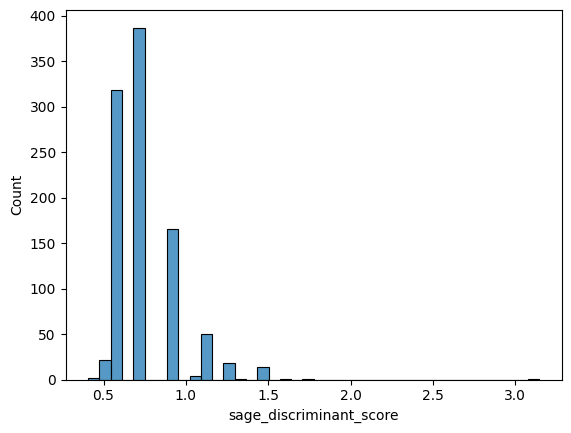

In [39]:
sns.histplot(
    dp.sort_values('rank'),
    x='sage_discriminant_score'
)

### 2.2 Expand

# 3. Score all candidates and calculate ambiguity

In [40]:
dp = fp.filter(pc.field('scannr') == 'controllerType=0 controllerNumber=1 scan=108570').to_pandas()

<Axes: xlabel='sage_discriminant_score', ylabel='Count'>

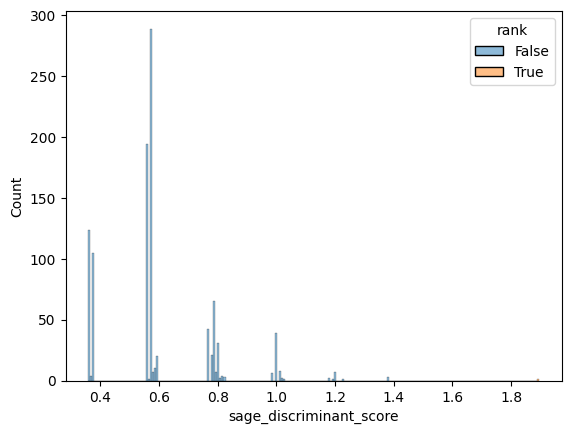

In [42]:
sns.histplot(
    dp,
    x='sage_discriminant_score',
    hue=dp['rank']==1
)

In [44]:
dp.peptide.apply(Peptidoform)

0      ((A, None), (I, None), (L, None), (G, None), (...
1      ((E, None), (G, None), (N, None), (E, None), (...
2      ((L, None), (S, None), (V, None), (A, None), (...
3      ((V, None), (L, None), (D, None), (V, None), (...
4      ((V, None), (K, None), (A, None), (C, [+57.021...
                             ...                        
995    ((M, None), (M, [+15.9949]), (N, None), (T, No...
996    ((E, None), (Q, None), (R, None), (V, None), (...
997    ((A, None), (Y, None), (Y, None), (W, None), (...
998    ((N, None), (G, None), (H, None), (S, None), (...
999    ((S, None), (E, None), (V, None), (L, None), (...
Name: peptide, Length: 1000, dtype: object